**W2_Generaive Modeling 1**

# Winery classification using the one-dimensional Gaussian

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# Useful module for dealing with the Gaussian density
from scipy.stats import norm, multivariate_normal
# installing packages for interactive graphs
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider

In [4]:
# 'wine.data.txt' needs to be in the same directory
data = np.loadtxt('/Documents/Machine_learning/winery-univariate/wine.data.txt', delimiter=',')
# Names of features
featurenames = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash','Magnesium', 'Total phenols', 
                'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 
                'OD280/OD315 of diluted wines', 'Proline']

In [6]:
# split data randomly
np.random.seed(0)
perm = np.random.permutation(178) #178个样本
trainx = data[perm[0:130],1:14]
trainy = data[perm[0:130],0]
testx = data[perm[130:178], 1:14]
testy = data[perm[130:178],0]

In [18]:
train_class, train_class_num = np.unique(testy, return_counts = True)
stat = dict(zip(train_class, train_class_num))
stat

{1.0: 16, 2.0: 17, 3.0: 15}

In [8]:
stat[1]

43

In [9]:
testx.shape

(48, 13)

## 2. Look at the distribution of a single feature from one of the wineries

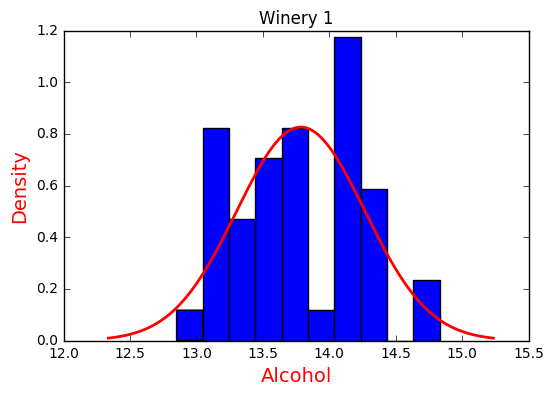

In [10]:
@interact_manual( feature=IntSlider(0,0,12), label=IntSlider(1,1,3))
def density_plot(feature, label):
    plt.hist(trainx[trainy==label,feature], normed=True)
    #
    mu = np.mean(trainx[trainy==label,feature]) # mean
    var = np.var(trainx[trainy==label,feature]) # variance
    std = np.sqrt(var) # standard deviation
    #
    x_axis = np.linspace(mu - 3*std, mu + 3*std, 1000)
    plt.plot(x_axis, norm.pdf(x_axis,mu,std), 'r', lw=2)
    plt.title("Winery "+str(label) )
    plt.xlabel(featurenames[feature], fontsize=14, color='red')
    plt.ylabel('Density', fontsize=14, color='red')
    plt.show()
    
#interact(density_plot,feature=IntSlider(0,0,12), label=IntSlider(1,1,3))

In [17]:
std = np.zeros(13)
for feature in range(0,13):
    std[feature] = np.std(trainx[trainy==1,feature])
np.argmin(std)

7

## 3. Fit a Gaussian to each class

In [19]:
# Assumes y takes on values 1,2,3
def fit_generative_model(x,y,feature):
    k = 3 # number of classes
    mu = np.zeros(k+1) # list of means
    var = np.zeros(k+1) # list of variances
    pi = np.zeros(k+1) # list of class weights
    for label in range(1,k+1):
        indices = (y==label)
        mu[label] = np.mean(x[indices,feature])
        var[label] = np.var(x[indices,feature])
        pi[label] = float(sum(indices))/float(len(y))
    return mu, var, pi

In [21]:
feature = 0 # 'alcohol'
mu, var, pi = fit_generative_model(trainx, trainy, feature)
print(pi[1:])

[ 0.33076923  0.41538462  0.25384615]


In [22]:
pi.shape

(4,)

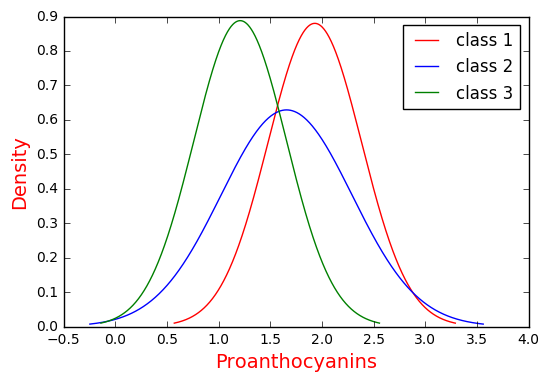

In [24]:
#@interact_manual( feature=IntSlider(0,0,12) )
def show_densities(feature):
    mu, var, pi = fit_generative_model(trainx, trainy, feature)
    colors = ['r', 'b', 'g']
    for label in range(1,4):
        m = mu[label]
        s = np.sqrt(var[label])
        x_axis = np.linspace(m - 3*s, m+3*s, 1000)
        plt.plot(x_axis, norm.pdf(x_axis,m,s), colors[label-1], label="class " + str(label))
    plt.xlabel(featurenames[feature], fontsize=14, color='red')
    plt.ylabel('Density', fontsize=14, color='red')
    plt.legend()
    plt.show()
interact(show_densities,feature=IntSlider(0,0,12))

## 4. Predict labels for the test set

In [27]:
#@interact( feature=IntSlider(0,0,12) )
def test_model(feature):
    mu, var, pi = fit_generative_model(trainx, trainy, feature)

    k = 3 # Labels 1,2,...,k
    n_test = len(testy) # Number of test points
    score = np.zeros((n_test,k+1))
    for i in range(0,n_test):
        for label in range(1,k+1):
            score[i,label] = np.log(pi[label]) + \
            norm.logpdf(testx[i,feature], mu[label], np.sqrt(var[label]))
    predictions = np.argmax(score[:,1:4], axis=1) + 1
    # Finally, tally up score
    errors = np.sum(predictions != testy)
    return errors/n_test
#    print("Test error using feature " + featurenames[feature] + ": " + str(errors) + "/" + str(n_test))

0.60416666666666663

In [81]:
result = []
for i in range(13):
    result += [test_model(i)]
arr = np.array([result])
arr.argsort()

array([[ 6,  9, 10,  5,  8,  0, 12, 11,  4,  1,  3,  7,  2]], dtype=int64)

In [75]:
#@interact( feature=IntSlider(0,0,12) )
def train_model(feature):
    mu, var, pi = fit_generative_model(trainx, trainy, feature)

    k = 3 # Labels 1,2,...,k
    n_train = len(trainy) # Number of train points
    score = np.zeros((n_train,k+1))
    for i in range(0,n_train):
        for label in range(1,k+1):
            score[i,label] = np.log(pi[label]) + \
            norm.logpdf(trainx[i,feature], mu[label], np.sqrt(var[label]))
    predictions = np.argmax(score[:,1:4], axis=1) + 1
    # Finally, tally up score
    errors = np.sum(predictions != trainy)
    return errors/n_train
#    print("Test error using feature " + featurenames[feature] + ": " + str(errors) + "/" + str(n_test))

In [79]:
train_result = []
for i in range(13):
    train_result += [train_model(i)]
arr2 = np.array([train_result])
arr2

array([[ 0.33846154,  0.37692308,  0.50769231,  0.52307692,  0.46923077,
         0.35384615,  0.20769231,  0.42307692,  0.46153846,  0.29230769,
         0.36923077,  0.36153846,  0.26923077]])

In [80]:
arr2.argsort()

array([[ 6, 12,  9,  0,  5, 11, 10,  1,  7,  8,  4,  2,  3]], dtype=int64)

# Experiments with the bivariate Gaussian

Covariance matrix:
[[ 9.   -0.45]
 [-0.45  9.  ]]


C:\Users\tp179902741\Anaconda3\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
C:\Users\tp179902741\Anaconda3\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


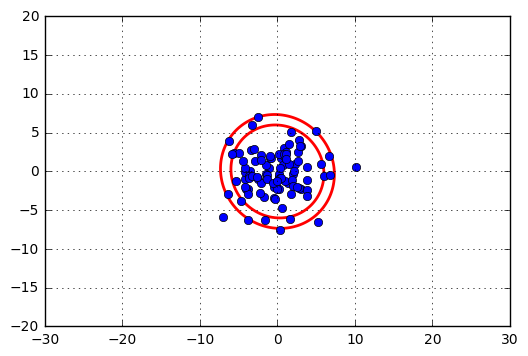

In [136]:
@interact_manual(var1 = (1,9), var2 = (1,9), corr=(-0.95,0.95,0.05))
def bivariate_plot(var1, var2, corr):
    #
    # Set parameters of Gaussian
    mu = [0,0]
    covariance = corr * np.sqrt(var1) * np.sqrt(var2)
    sigma = [[var1,covariance], [covariance,var2]]
    np.set_printoptions(precision=2)
    print ("Covariance matrix:")
    print (np.around(sigma, decimals=2))
    #
    # Draw samples from the distribution
    n = 100
    x = np.random.multivariate_normal(mu,sigma,size=n)
    #
    # Set up a plot for the samples and the density contours
    lim = 20.0
    plt.xlim(-lim, lim) # limit along x1-axis
    plt.ylim(-lim, lim) # limit along x2-axis    
    plt.axes().set_aspect('equal', 'datalim')
    #
    # Plot the sampled points as blue dots
    plt.plot(x[:,0], x[:,1], 'bo')
    #
    # To display contour lines, first define a fine grid
    res = 200
    xg = np.linspace(-lim, lim, res)
    yg = np.linspace(-lim, lim, res)
    z = np.zeros((res,res))
    # Compute the density at each grid point
    rv = multivariate_normal(mean=mu, cov=sigma)
    for i in range(0,res):
        for j in range(0,res):
            z[j,i] = rv.logpdf([xg[i], yg[j]]) 
    sign, logdet = np.linalg.slogdet(sigma)
    normalizer = -0.5 * (2 * np.log(6.28) + sign * logdet)
    # Now plot a few contour lines of the density
    for offset in range(2,4):
        plt.contour(xg,yg,z, levels=[normalizer - offset], colors='r', linewidths=2.0, linestyles='solid')

    # Finally, display
    plt.grid(True)
    plt.show()

In [129]:
xlist = np.linspace(1, 6, 6) # Create 1-D arrays for x,y dimensions
ylist = np.linspace(6, 10, 5)
X,Y = np.meshgrid(xlist, ylist) # Create 2-D grid xlist,ylist values
#Z = np.sqrt(X**2 + Y**2)

In [130]:
xlist

array([ 1.,  2.,  3.,  4.,  5.,  6.])

In [131]:
X

array([[ 1.,  2.,  3.,  4.,  5.,  6.],
       [ 1.,  2.,  3.,  4.,  5.,  6.],
       [ 1.,  2.,  3.,  4.,  5.,  6.],
       [ 1.,  2.,  3.,  4.,  5.,  6.],
       [ 1.,  2.,  3.,  4.,  5.,  6.]])

In [132]:
ylist

array([  6.,   7.,   8.,   9.,  10.])

In [133]:
Y

array([[  6.,   6.,   6.,   6.,   6.,   6.],
       [  7.,   7.,   7.,   7.,   7.,   7.],
       [  8.,   8.,   8.,   8.,   8.,   8.],
       [  9.,   9.,   9.,   9.,   9.,   9.],
       [ 10.,  10.,  10.,  10.,  10.,  10.]])

# Winery classification with the bivariate Gaussian

In [82]:
# Load data set.
data = np.loadtxt('C:/Users/tp179902741/Documents/Machine_learning/winery-bivariate/wine.data.txt', delimiter=',')
# Names of features
featurenames = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash','Magnesium', 'Total phenols', 
                'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 
                'OD280/OD315 of diluted wines', 'Proline']
# Split 178 instances into training set (trainx, trainy) of size 130 and test set (testx, testy) of size 48
np.random.seed(0)
perm = np.random.permutation(178)
trainx = data[perm[0:130],1:14]
trainy = data[perm[0:130],0]
testx = data[perm[130:178], 1:14]
testy = data[perm[130:178],0]

In [83]:
# Fit a Gaussian to a data set using the selected features
def fit_gaussian(x, features):
    mu = np.mean(x[:,features], axis=0)
    covar = np.cov(x[:,features], rowvar=0, bias=1)
    return mu, covar

In [85]:
f1 = 0
f2 = 6
label = 1
mu, covar = fit_gaussian(trainx[trainy==label,:], [f1,f2])
print("Mean:\n" + str(mu))
print("Covariance matrix:\n" + str(covar))

Mean:
[ 13.78534884   2.99627907]
Covariance matrix:
[[ 0.23325279  0.07526874]
 [ 0.07526874  0.15240941]]


In [86]:
# Find the range within which an array of numbers lie, with a little buffer
def find_range(x):
    lower = min(x)
    upper = max(x)
    width = upper - lower
    lower = lower - 0.2 * width
    upper = upper + 0.2 * width
    return lower, upper

In [90]:
def plot_contours(mu, cov, x1g, x2g, col):
    rv = multivariate_normal(mean=mu, cov=cov)
    z = np.zeros((len(x1g),len(x2g)))
    for i in range(0,len(x1g)):
        for j in range(0,len(x2g)):
            z[j,i] = rv.logpdf([x1g[i], x2g[j]]) 
    sign, logdet = np.linalg.slogdet(cov)
    normalizer = -0.5 * (2 * np.log(6.28) + sign * logdet)#???
    for offset in range(1,4):
        plt.contour(x1g,x2g,z, levels=[normalizer - offset], colors=col, linewidths=2.0, linestyles='solid')

C:\Users\tp179902741\Anaconda3\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
C:\Users\tp179902741\Anaconda3\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


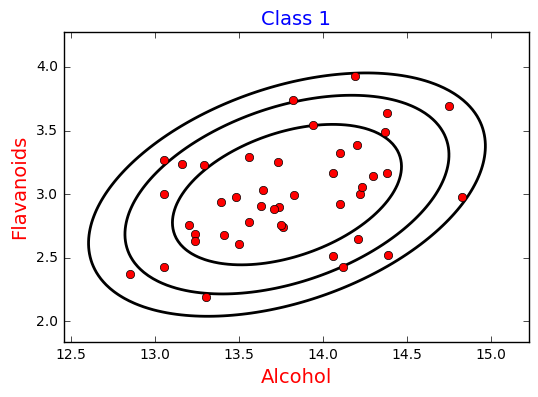

In [96]:
interact(two_features_plot, f1=IntSlider(0,0,12,1), f2=IntSlider(6,0,12,1), label=IntSlider(1,1,3,1))
def two_features_plot(f1,f2,label):
    if f1 == f2: # we need f1 != f2
        print("Please choose different features for f1 and f2.")
        return  
    
    # Set up plot
    x1_lower, x1_upper = find_range(trainx[trainy==label,f1])
    x2_lower, x2_upper = find_range(trainx[trainy==label,f2])
    plt.xlim(x1_lower, x1_upper) # limit along x1-axis
    plt.ylim(x2_lower, x2_upper) # limit along x2-axis
    
    # Plot the training points along the two selected features
    plt.plot(trainx[trainy==label, f1], trainx[trainy==label, f2], 'ro')

    # Define a grid along each axis; the density will be computed at each grid point
    res = 250 # resolution
    x1g = np.linspace(x1_lower, x1_upper, res)
    x2g = np.linspace(x2_lower, x2_upper, res)

    # Now plot a few contour lines of the density
    mu, cov = fit_gaussian(trainx[trainy==label,:], [f1,f2])
    plot_contours(mu, cov, x1g, x2g, 'k')
    
    # Finally, display
    plt.xlabel(featurenames[f1], fontsize=14, color='red')
    plt.ylabel(featurenames[f2], fontsize=14, color='red')
    plt.title('Class ' + str(label), fontsize=14, color='blue')
    plt.show()

## 3. Fit a Gaussian to each class

In [97]:
# Assumes y takes on values 1,2,3
def fit_generative_model(x, y, features):
    k = 3 # number of classes
    d = len(features) # number of features
    mu = np.zeros((k+1,d)) # list of means
    covar = np.zeros((k+1,d,d)) # list of covariance matrices
    pi = np.zeros(k+1) # list of class weights
    for label in range(1,k+1):
        indices = (y==label)
        mu[label,:], covar[label,:,:] = fit_gaussian(x[indices,:], features)
        pi[label] = float(sum(indices))/float(len(y))
    return mu, covar, pi

C:\Users\tp179902741\Anaconda3\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
C:\Users\tp179902741\Anaconda3\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


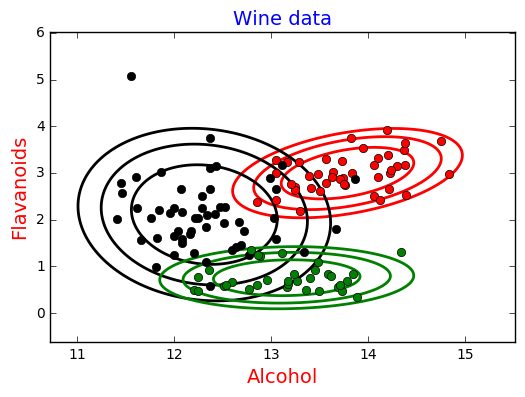

In [99]:
@interact_manual( f1=IntSlider(0,0,12,1), f2=IntSlider(6,0,12,1) )
def three_class_plot(f1,f2):
    if f1 == f2: # we need f1 != f2
        print ("Please choose different features for f1 and f2.")
        return  
    
    # Set up plot
    x1_lower, x1_upper = find_range(trainx[:,f1])
    x2_lower, x2_upper = find_range(trainx[:,f2])
    plt.xlim(x1_lower, x1_upper) # limit along x1-axis
    plt.ylim(x2_lower, x2_upper) # limit along x2-axis
    
    # Plot the training points along the two selected features
    colors = ['r', 'k', 'g']
    for label in range(1,4):
        plt.plot(trainx[trainy==label,f1], trainx[trainy==label,f2], marker='o', ls='None', c=colors[label-1])

    # Define a grid along each axis; the density will be computed at each grid point
    res = 200 # resolution
    x1g = np.linspace(x1_lower, x1_upper, res)
    x2g = np.linspace(x2_lower, x2_upper, res)

    # Show the Gaussian fit to each class, using features f1,f2
    mu, covar, pi = fit_generative_model(trainx, trainy, [f1,f2])
    for label in range(1,4):
        gmean = mu[label,:]
        gcov = covar[label,:,:]
        plot_contours(gmean, gcov, x1g, x2g, colors[label-1])

    # Finally, display
    plt.xlabel(featurenames[f1], fontsize=14, color='red')
    plt.ylabel(featurenames[f2], fontsize=14, color='red')
    plt.title('Wine data', fontsize=14, color='blue')
    plt.show()

## 4. Predict labels for the test points

In [110]:
# Now test the performance of a predictor based on a subset of features
@interact( f1=IntSlider(0,0,12,1), f2=IntSlider(6,0,12,1) )
def test_model(f1, f2):
    if f1 == f2: # need f1 != f2
        print("Please choose different features for f1 and f2.")
        return  
    features= [f1,f2]
    mu, covar, pi = fit_generative_model(trainx, trainy, features)
    
    k = 3 # Labels 1,2,...,k
    nt = len(testy) # Number of test points
    score = np.zeros((nt,k+1))
    for i in range(0,nt):
        for label in range(1,k+1):
            score[i,label] = np.log(pi[label]) + \
            multivariate_normal.logpdf(testx[i,features], mean=mu[label,:], cov=covar[label,:,:])
    predictions = np.argmax(score[:,1:4], axis=1) + 1
    # Finally, tally up score
    errors = np.sum(predictions != testy)
#    return errors/nt
    print ("Test error using feature(s): ")
    for f in features:
        print ("'" + featurenames[f] + "'" + " ")
    print()
    print ("Errors: " + str(errors) + "/" + str(nt))# Now test the performance of a predictor based on a subset of features

Test error using feature(s): 
'Flavanoids' 
'Color intensity' 

Errors: 3/48


In [ ]:
result = []
for i in range(12):
    for j in range(i+1,13):
        result += [test_model(i, j)]
result

In [108]:
np.argmin(result)

59

In [109]:
result[59]

0.0625

## 5. The decision boundary 

The function show_decision_boundary takes as input two features, builds a classifier based only on these two features, and shows a plot that contains both the training data and the decision boundary.

To compute the decision boundary, a dense grid is defined on the two-dimensional input space and the classifier is applied to every grid point. The built-in pyplot.contour function can then be invoked to depict the boundary.

In [ ]:
def show_decision_boundary(f1,f2):
    # Fit Gaussian to each class
    mu, covar, pi = fit_generative_model(trainx, trainy, [f1,f2])
    
    # Set up dimensions of plot
    x1_lower, x1_upper = find_range(trainx[:,f1])
    x2_lower, x2_upper = find_range(trainx[:,f2])
    plt.xlim([x1_lower,x1_upper])
    plt.ylim([x2_lower,x2_upper])

    # Plot points in training set
    colors = ['r', 'k', 'g']
    for label in range(1,4):
        plt.plot(trainx[trainy==label,f1], trainx[trainy==label,f2], marker='o', ls='None', c=colors[label-1])

    # Define a dense grid; every point in the grid will be classified according to the generative model
    res = 200
    x1g = np.linspace(x1_lower, x1_upper, res)
    x2g = np.linspace(x2_lower, x2_upper, res)

    # Declare random variables corresponding to each class density
    random_vars = {}
    for label in range(1,4):
        random_vars[label] = multivariate_normal(mean=mu[label,:],cov=covar[label,:,:])

    # Classify every point in the grid; these are stored in an array Z[]
    Z = np.zeros((len(x1g), len(x2g)))
    for i in range(0,len(x1g)):
        for j in range(0,len(x2g)):
            scores = []
            for label in range(1,4):
                scores.append(np.log(pi[label]) + random_vars[label].logpdf([x1g[i],x2g[j]]))
            Z[i,j] = np.argmax(scores) + 1

    # Plot the contour lines
    plt.contour(x1g,x2g,Z.T,3,cmap='seismic')
    
    # Finally, show the image
    plt.xlabel(featurenames[f1], fontsize=14, color='red')
    plt.ylabel(featurenames[f2], fontsize=14, color='red')
    plt.show()

In [ ]:
show_decision_boundary(0,6)